In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the stock pairs
stock_pairs = [
    ("WM", "RSG"),
    ("UAL", "DAL"),
    ("V", "MA"),
    ("MS", "GS"),
    ("NVDA", "AMD"),
    ("CVX", "XOM")
]

# Define the start and end dates
start_date = "2021-01-01"
end_date = "2022-12-31"

Six pairs of stocks are selected from six different sectors in the US market. WM-RSG, UAL-DAL, V-MA, MS-GS, NVDA-AMD, and CVX-XOM. We collect the daily close prices for these stocks from 1/1/2021 to 12/31/2022 using the Yahoo! Finance API.

In [ ]:

# # Create an empty DataFrame to store the results
# all_data = pd.DataFrame()

# for pair in stock_pairs:
#     for stock in pair:
#         # Fetch the stock data
#         data = yf.download(stock, start=start_date, end=end_date)
#         # Only keep the adjusted close price
#         data = data[['Adj Close']].rename(columns={'Adj Close': stock})
#         # Merge with the main DataFrame
#         if all_data.empty:
#             all_data = data
#         else:
#             all_data = all_data.join(data, how='outer')

# # Display the first few rows of the DataFrame
# print(all_data.head())

# # Save the data to a CSV file
# # all_data.to_csv('adjusted_close_prices.csv')


Each price time series has been divided by its initial values for normalization. As we can see, the stock prices for each pair exhibit persistent comovement.

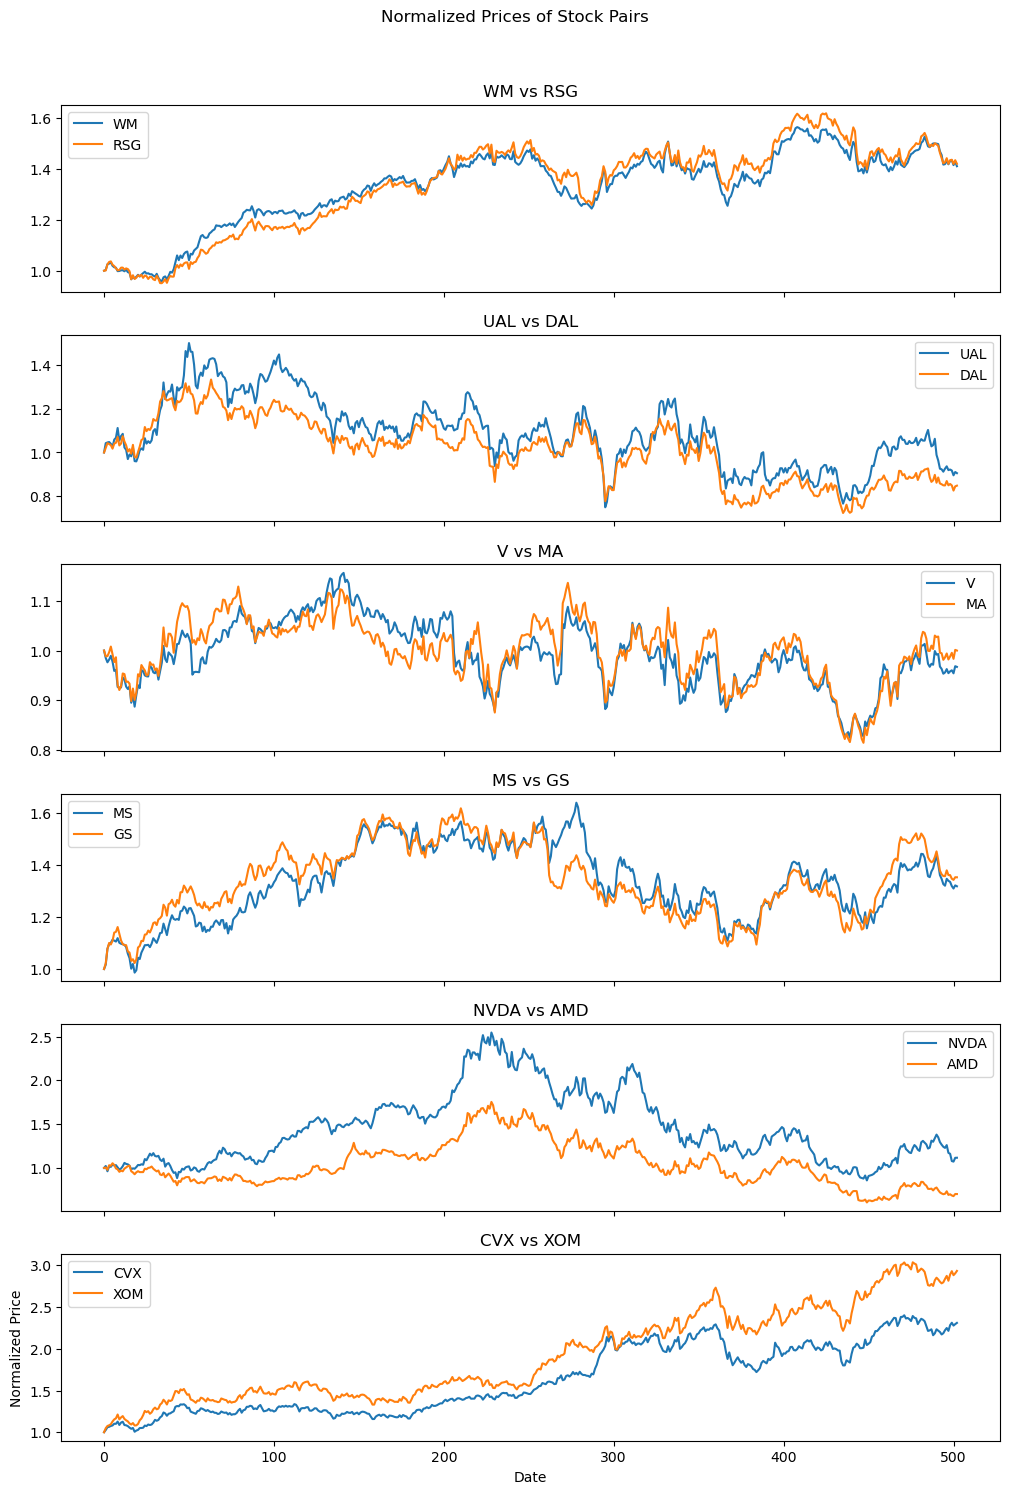

In [3]:
import yfinance as yf
import pandas as pd

all_data = pd.read_csv("adjusted_close_prices.csv")

# Create a figure with subplots
fig, axes = plt.subplots(len(stock_pairs), 1, figsize=(10, 15), sharex=True)
fig.suptitle('Normalized Prices of Stock Pairs')

# Iterate over each stock pair and fetch data
for i, (stock1, stock2) in enumerate(stock_pairs):
    # Fetch data for both stocks
    data1 = all_data[stock1]
    data2 = all_data[stock2]

    # Normalize the prices
    norm_data1 = data1 / data1.iloc[0]
    norm_data2 = data2 / data2.iloc[0]

    # Plot the data
    axes[i].plot(norm_data1, label=stock1)
    axes[i].plot(norm_data2, label=stock2)
    axes[i].set_title(f'{stock1} vs {stock2}')
    axes[i].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.show()


In [4]:
def computeLogLikelihood(mu, theta, sigma_sq, past_x, dt=1):
    L = len(past_x)
    s = sigma_sq * (1 - np.exp(-2*mu*dt)) / 2 / mu
    ans = -0.5 * np.log(2*np.pi) - np.log(np.sqrt(s))
    diff = past_x[1:] - past_x[:-1] * np.exp(-mu*dt) - theta*(1-np.exp(-mu*dt))
    ans -= 0.5/L/s * sum(diff**2)

    return ans

def optimOUParamter(x, dt=1):
    n = len(x)

    Xx = np.sum(x[:-1])
    Xy = Xx + x[-1] - x[0]
    
    Xxx = np.sum(x[:-1]**2)
    Xxy = np.sum(x[:-1] * x[1:])
    Xyy = Xxx + x[-1]**2 - x[0]**2
    
    theta = (Xy * Xxx - Xx * Xxy)/(n * (Xxx - Xxy) - (Xx**2 - Xx * Xy))
    mu = -1/dt * np.log((Xxy - theta * Xx - theta * Xy + n*theta**2)/(Xxx - 2*theta*Xx + n*theta**2))
    e = np.exp(-mu*dt)
    sigma_sq = 2*mu /n/(1 - e*e) * (Xyy - 2*e*Xxy + e*e*Xxx 
                        -2*theta*(1-e)*(Xy - e*Xx) + n * theta**2 * (1-e)**2)
    return theta, mu, sigma_sq

def getPastSpread(x, L):
    return x[-L:]

def gridsearchHedgeRatio(S1, S2, limit_ratio=2, grid_spacing=0.01):
    ans = 0
    max_l = -np.inf
    candidates = np.linspace(-limit_ratio, limit_ratio, round(2*(limit_ratio)/grid_spacing)+1)
    optim_param = []
    for b in candidates:
        theta, mu, sigma_sq = optimOUParamter(S1 - b*S2)
        past_x = getPastSpread(S1-b*S2, L=252)
        l = computeLogLikelihood(mu, theta, sigma_sq, past_x)
        if l > max_l:
            ans = b
            max_l = l
            optim_param = [theta, mu, sigma_sq]
    return ans, max_l, optim_param


In the formation period, we use the data from 01/01/2021 to 12/31/2021 to compute the optimal ratio for each pair. The estimated best ratio and likelihood score of each pair is computed. 

In [5]:
# filter_date = '2022-01-01'

ratio = []
likelihood = []
OU_param = []

for i, (stock1, stock2) in enumerate(stock_pairs):
    # Fetch data for both stocks
    data1 = all_data[stock1]
    data2 = all_data[stock2]

    data1 = data1[data1.index < 253]
    data2 = data2[data2.index < 253]

    # Normalize the prices
    norm_data1 = data1 / data1.iloc[0]
    norm_data2 = data2 / data2.iloc[0]

    b, max_l, optim_param = gridsearchHedgeRatio(norm_data1.values, norm_data2.values)
    ratio.append(b)
    likelihood.append(max_l)
    OU_param.append(optim_param)
    print(stock1+","+stock2+f", b={b}, l={max_l}")


WM,RSG, b=0.8399999999999999, l=3.80009571188156
UAL,DAL, b=1.1800000000000002, l=2.8329319796875336
V,MA, b=0.7400000000000002, l=3.485489598900839
MS,GS, b=0.8700000000000001, l=3.1447213788332746
NVDA,AMD, b=1.08, l=2.025009556474643
CVX,XOM, b=0.6600000000000001, l=3.391391970347613


The log likelihood score and mean reversion rate are applied min-max normalization before entering into weight calculations.
Furthermore, the speed of mean reversion is scaled by volatility to account for fluctuations due to volatility.
$$
\hat{\mu}_{\mathrm{i}}^r=\frac{\hat{\mu}_{\mathrm{i}}}{\hat{\sigma}_{\mathrm{i}}},
$$
Lastly, we incorporate both quantities into the portfolio weight allocation. This results in the formula
$$
w_{\mathrm{i}}=\frac{\tilde{\mu}_{\mathrm{i}} \tilde{l}_{\mathrm{i}}}{\sum_{\mathrm{i}=1}^N \tilde{\mu}_{\mathrm{i}} \tilde{l}_{\mathrm{i}}}, \mathrm{i}=1, \cdots, N \text {. }
$$
This means that more capital is allocated into pairs that are more OU-like and mean-revert more rapidly.

In [13]:
def computeMRBWeights(OU_param, likelihood):
    normalized_l = (np.array(likelihood) - min(likelihood))/(max(likelihood) - min(likelihood))
    reduced_theta = np.array([OU_param[i][0]/np.sqrt(OU_param[i][2]) for i in range(6)])
    normalized_reduced_theta = (reduced_theta - min(reduced_theta))/(max(reduced_theta) - min(reduced_theta))

    denominator = sum(t*l for t, l in zip(normalized_reduced_theta, normalized_l))
    MRB_weights = [t*l/denominator for t, l in zip(normalized_reduced_theta, normalized_l)]
    return MRB_weights

MRB_weights = computeMRBWeights(OU_param, likelihood)
print(MRB_weights)

[0.35734119335456516, 0.0, 0.25818080981281794, 0.09873565920537548, 0.0, 0.2857423376272415]


We see from above that MRB weights tends to concentrate, which means some pairs never gets invested, while others occupy a large portion of total portfolio. Furthermore, the MRB method is susceptible to estimation errors since the portfolio weights are functions of the estimates.  
An alterantive approach is proposed, called Mean Reversion Ranking (MRR), which assigns fixed values based on the rankings of the product of the estimated likelihood score and speed of mean reversion. Assuming that n pairs are currently traded, we sort the n pairs in ascending order based on the product. Then, we calculate the weights of sorted pairs by
$$
\left(\frac{n-1}{2 n(n-1)}, \frac{n+1}{2 n(n-1)}, \cdots, \frac{3(n-1)}{2 n(n-1)}\right)
$$
The ranking method offers a more moderate weight distribution than the MRB method.

In [7]:
def computeMRRWeights(MRB_weights):
    ranks = np.argsort(np.array(MRB_weights)).argsort()
    n = len(ranks)
    MRR_weights = ranks * 1/n/(n-1) + 1/2/n
    return MRR_weights

MRR_weights = computeMRRWeights(MRB_weights)
print(MRR_weights)

[0.25       0.08333333 0.18333333 0.15       0.11666667 0.21666667]


In [10]:
spreads = []

for i, (stock1, stock2) in enumerate(stock_pairs):
    # Fetch data for both stocks
    data1 = all_data[stock1]
    data2 = all_data[stock2]

    data1 = data1[data1.index < 253]
    data2 = data2[data2.index < 253]

    # Normalize the prices
    norm_data1 = data1 / data1.iloc[0]
    norm_data2 = data2 / data2.iloc[0]

    spreads.append(norm_data1 - ratio[i]*norm_data2)

df_spreads = pd.DataFrame(np.array(spreads).T, np.arange(len(spreads[0])), columns=stock_pairs)

,"(WM, RSG)","(UAL, DAL)","(V, MA)","(MS, GS)","(NVDA, AMD)","(CVX, XOM)"
0,0.160000,-0.180000,0.260000,0.130000,-0.080000,0.340000
1,0.162411,-0.162466,0.253644,0.127508,-0.063289,0.335226
2,0.164503,-0.184391,0.244691,0.140830,-0.095001,0.350627
3,0.159036,-0.177899,0.244359,0.139244,-0.095888,0.350019
4,0.162029,-0.179428,0.243479,0.148935,-0.094229,0.352220
...,...,...,...,...,...,...
248,0.203583,-0.119984,0.244198,0.203080,0.522289,0.431535
249,0.205561,-0.125842,0.243674,0.189210,0.555007,0.433072
250,0.207351,-0.129392,0.242922,0.192530,0.559722,0.432689
251,0.205579,-0.139018,0.241096,0.192862,0.560992,0.424943


<Axes: >

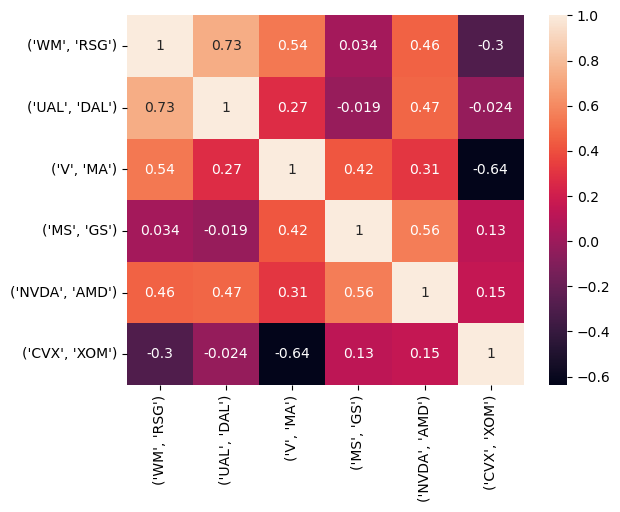

In [12]:
import seaborn
seaborn.heatmap(df_spreads.corr(), annot=True)